In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [7]:
%cd /content/drive/My\ Drive/IIM\ Project/CART\ Model/

/content/drive/My Drive/IIM Project/CART Model


#Importing Libraries and Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Reading Data
df = pd.read_csv("btrain.csv")
df_test = pd.read_csv("btest.csv")
df_validate = pd.read_csv("bvalidate.csv") #Validation Data file given seperately

In [3]:
# Making Classifier column name consistent in all datasets
df_validate.rename(columns={' winner':'winner'}, inplace=True) 
df_test.rename(columns={' winner':'winner'}, inplace=True)

In [4]:
df = df[df.winner != '?']
df_validate = df_validate[df_validate.winner != '?']
df = df.reset_index(drop=True)
df_validate = df_validate.reset_index(drop=True)

Above code basically removes those rows which have missing labels

In [5]:
# Storing number of rows in each dataset
ntrain = df.shape[0]
nvalidate = df_validate.shape[0]
ntest = df_test.shape[0]

#Pre Processing

In [6]:

# Storing independent/classifier variable seperately
y_train = df['winner']
y_validate = df_validate['winner']

# Combining datasets so that all the preprocessing changes can be done in all of them at the same time
all_data = pd.concat([df, df_validate, df_test], sort=False).reset_index(drop=True)
all_data.drop(['winner'], axis=1, inplace=True) # removing dependent variable from all drop
print(all_data.shape)

(66943, 13)


In [7]:
df['winner'].value_counts()

col_list = all_data.columns
print(col_list)
# Following information about categorical variables is obtained from data description already provided
cat_col_list = [' weather', ' startingpitcher', ' oppstartingpitcher', 
                ' homeaway']


Index(['winpercent', ' oppwinpercent', ' weather', ' temperature',
       ' numinjured', ' oppnuminjured', ' startingpitcher',
       ' oppstartingpitcher', ' dayssincegame', ' oppdayssincegame',
       ' homeaway', ' rundifferential', ' opprundifferential'],
      dtype='object')


In [8]:

# Finding all distinct values present in categorical variables
for i in range(0, len(cat_col_list)):
    print(all_data[cat_col_list[i]].unique())


['1' '?' '0' '-1']
['?' '2' '3' '5' '4' '1']
['5' '3' '2' '4' '1' '?']
['1' '0' '?']


In [9]:
frequent_value = y_validate.mode()[0]
all_data.replace('?', np.NaN, inplace = True)
# Replacing missing values in dependent variable based on mode of the classes
# This seems to be okay option for the given dataset since there is no class imbalance
# and I plan to do similar pre processing as done in code of C4.5 algo so that we can compare the results
# another approach is to remove such rows whose dependent variable is missing 
y_validate.replace('?', frequent_value, inplace = True)
y_train.replace('?', y_train.mode()[0], inplace = True) 

# yourValue = '?'
# for cols in df.columns:
# 	if (yourValue in df[cols]):
# 		print('Found in '+cols) #to print the column name if found

print(all_data.isnull().sum())

winpercent             3412
 oppwinpercent         3433
 weather               3331
 temperature           3331
 numinjured            3312
 oppnuminjured         3306
 startingpitcher       3499
 oppstartingpitcher    3289
 dayssincegame         3322
 oppdayssincegame      3313
 homeaway              3318
 rundifferential       3281
 opprundifferential    3299
dtype: int64


In [10]:


for column in col_list:
    all_data[column].fillna(all_data[column].mode()[0], inplace=True)
all_data.isnull().sum()


winpercent             0
 oppwinpercent         0
 weather               0
 temperature           0
 numinjured            0
 oppnuminjured         0
 startingpitcher       0
 oppstartingpitcher    0
 dayssincegame         0
 oppdayssincegame      0
 homeaway              0
 rundifferential       0
 opprundifferential    0
dtype: int64

### Preparing Modified data for modelling

In [11]:
# Encoding categorical variables, left one variable since it already have 0 and 1
# as factors in it
varia = pd.get_dummies(all_data.iloc[:, [2, 6, 7]])
print(varia.head)
print(varia.columns)

# Remove original categorical variables from main dataset and concating the 
# encoded categorical variable
all_data = all_data.drop([" weather", " oppstartingpitcher", " startingpitcher"], axis=1)



<bound method NDFrame.head of         weather_-1   weather_0   weather_1   startingpitcher_1  \
0                0           0           1                   0   
1                0           1           0                   0   
2                0           1           0                   0   
3                0           0           1                   0   
4                1           0           0                   0   
...            ...         ...         ...                 ...   
66938            1           0           0                   0   
66939            0           1           0                   1   
66940            0           1           0                   1   
66941            0           1           0                   0   
66942            0           1           0                   0   

        startingpitcher_2   startingpitcher_3   startingpitcher_4  \
0                       0                   0                   1   
1                       1              

In [12]:
final_all_data = pd.concat([all_data, varia], axis=1)
print(final_all_data.shape)

# Dividing modified data again into train test and validation sets
X_train = final_all_data[:ntrain]
X_validate = final_all_data[ntrain:ntrain + nvalidate]
X_test = final_all_data[ntrain + nvalidate:]

(66943, 23)


#Model Making

In [13]:


from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score 
scv = StratifiedKFold(n_splits=5)

# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10, 20]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4, 10, 16]
# Create the random grid
random_grid = {'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}  
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = DecisionTreeClassifier(random_state=0)
# Random search of parameters, using 3 fold cross validation, 
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid,
                n_iter = 100, cv = scv, verbose=20, n_jobs = -1)

In [14]:
# Fit the random search model
rf_random.fit(X_train, y_train)
print(rf_random.best_params_)
print(rf_random.best_score_)


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed:   

{'min_samples_split': 20, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 110}
0.8574923031504365


### Hyperparameter tuning

In [14]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'max_depth': [20, 25, 30],
    'max_features': ['sqrt', 'auto'],
    'min_samples_leaf': [2, 4, 8, 12],
    'min_samples_split': [16, 20, 24]}


# Instantiate the grid search model
from sklearn.model_selection import GridSearchCV

grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = scv, n_jobs = -1, verbose = 4)
grid_search.fit(X_train, y_train)
print(grid_search.best_params_)
print(grid_search.best_score_)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:   10.9s
[Parallel(n_jobs=-1)]: Done 205 tasks      | elapsed:   26.8s
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:   47.4s finished


{'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 8, 'min_samples_split': 20}
0.862279374278951


### Final Model



In [15]:
# Training model with best set of parameters obtained from grid search
DTC = DecisionTreeClassifier(random_state=0, max_depth=20, max_features='sqrt', 
                             min_samples_leaf=8, min_samples_split= 20)
DTC.fit(X_train, y_train)
y_valid = DTC.predict(X_validate)

# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
from sklearn import metrics

cm = confusion_matrix(y_validate, y_valid)
report = metrics.classification_report(y_validate, y_valid, labels=[0,1])
print(report)

              precision    recall  f1-score   support

           0       0.79      0.80      0.80      3622
           1       0.88      0.87      0.87      5899

   micro avg       0.84      0.84      0.84      9521
   macro avg       0.83      0.84      0.83      9521
weighted avg       0.84      0.84      0.84      9521



C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\arraysetops.py:564: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask &= (ar1 != a)


In [16]:
train_accuracy = DTC.score(X_train, y_train)
print(train_accuracy)
validation_accuracy = DTC.score(X_validate, y_validate)
print(validation_accuracy)

0.8889123191767534
0.8427686167419389


### Pruning Tree

In [17]:
# let's observe the differnce using tree pruning
path = DTC.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

Text(0.5, 1.0, 'Total Impurity vs effective alpha for training set')

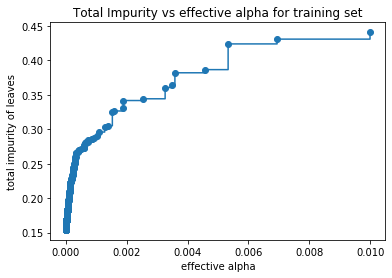

In [18]:
fig, ax = plt.subplots()
ax.plot(ccp_alphas[:-1], impurities[:-1], marker='o', drawstyle="steps-post")
ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Total Impurity vs effective alpha for training set")

In [19]:
clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=0, max_depth=20, max_features='sqrt', 
                             min_samples_leaf=8, min_samples_split= 20
                             , ccp_alpha=ccp_alpha)
    clf.fit(X_train, y_train)
    clfs.append(clf)
print("Number of nodes in the last tree is: {} with ccp_alpha: {}".format(
    clfs[-1].tree_.node_count, ccp_alphas[-1]))

Number of nodes in the last tree is: 1 with ccp_alpha: 0.015818904951789364


In [20]:
clfs = clfs[:-1]
ccp_alphas = ccp_alphas[:-1]

train_scores = [clf.score(X_train, y_train) for clf in clfs]
test_scores = [clf.score(X_validate, y_validate) for clf in clfs]


In [21]:
import operator
index, max_score = max(enumerate(train_scores), key=operator.itemgetter(1))
index1, max_score1 = max(enumerate(test_scores), key=operator.itemgetter(1))
print(index  ," " , index1)
print(max_score, " ", max_score1)
# Observed no signigicant change due to tree pruning

0   1006
0.8889123191767534   0.8507509715366033


### Final Model after pruning

In [22]:
DTC = DecisionTreeClassifier(random_state=0, max_depth=20, max_features='sqrt', 
                             min_samples_leaf=8, min_samples_split= 20, ccp_alpha=ccp_alphas[index1])
DTC.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=5.0228679609557684e-05, class_weight=None,
                       criterion='gini', max_depth=20, max_features='sqrt',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=8,
                       min_samples_split=20, min_weight_fraction_leaf=0.0,
                       presort='deprecated', random_state=0, splitter='best')

In [23]:
y_test_preds = DTC.predict(X_test)

### Creating final results

In [30]:
submission_format = pd.DataFrame(y_test_preds)
submission_format.columns = ['winner']
#df_test.drop('winner', axis=1, inplace=True) # removing dependent variable from all drop
FinalSubmission = pd.concat([df_test, submission_format], axis=1)
FinalSubmission.to_csv(r"C:\Users\Syed Abdullah Ashraf\Downloads\ANN\CART Model\results1.csv", header=True, index=None)